# Anomaly Detection Model

In [1]:
#%%writefile anomaly_detection.py
import math
import configurations
from collections import defaultdict
from typing import Tuple, Dict, List, NamedTuple, Set, Optional

import numpy as np
import pandas as pd

import configurations

AGGS = {
    configurations.USER_ID_COL: ['size', 'nunique'],
    configurations.ROUTE_COL: ['size', 'nunique']
}

class EngineeredFeaturesOrganizer(NamedTuple):
    all_new_features: Set[str]
    all_new_features_classified: Optional[Dict[str, Set[str]]] = None
        
        
class AnomalyDetectionTrainingResponse(NamedTuple):
    events_groups_data: pd.DataFrame
    groupby_time_interval_col_name: str
    lag_features_organizer: EngineeredFeaturesOrganizer
    diffs_features_organizer: EngineeredFeaturesOrganizer
    moving_averages_features_organizer: EngineeredFeaturesOrganizer
    
    
def generate_time_intervals(unix_start_time: int, unix_end_time: int, 
                            time_interval: int) -> Dict[int, int]:
    """
    This function generate time intervals (by seconds) ranges by the user specific request
    """
    still_remain = True
    
    alternative_time: Dict[int, int] = dict()
    lower_boundry = unix_start_time
    
    while still_remain:
        upper_boundry = lower_boundry + time_interval
        mean_value = lower_boundry + math.ceil(0.5*time_interval)
        
        for unix_second in range(lower_boundry, upper_boundry):
            alternative_time[unix_second] = mean_value
        
        if upper_boundry > unix_end_time:
            still_remain = False
        
        else:
            lower_boundry = upper_boundry
            
    return alternative_time


def set_time_intervals(rawdata: pd.DataFrame, time_interval: int) -> pd.DataFrame:
    """
    This function add column with an alternative timestamps value according the intervla
    provided in the time_interval input
    """
    unix_start_time = rawdata[configurations.UNIX_TIMESTAMP_COL].min()
    unix_end_time = rawdata[configurations.UNIX_TIMESTAMP_COL].max()
    
    time_intervals = generate_time_intervals(unix_start_time, unix_end_time, 
                        time_interval)
        
    time_window_col = f'interval_window_{time_interval}_sec'
    rawdata[time_window_col] = rawdata[configurations.UNIX_TIMESTAMP_COL].map(
        time_intervals)
        
    return rawdata, time_window_col


def aggregate_events_data(rawdata: pd.DataFrame, dimensions: List[str], period_col: str, aggregations: Dict[str, str] = AGGS):
    """
    This function activatea groupby operation in order to count the events in certain time window
    """
    groupby_cols = dimensions+[period_col]
    events_groups_data = rawdata.groupby(groupby_cols).agg(aggregations).reset_index()
    
    new_cols_name = [f'{attribute}_{measure}' for attribute, measure in events_groups_data.columns[len(groupby_cols):]]
    events_groups_data.columns = groupby_cols + new_cols_name
    
    events_groups_data['requests_per_user'] = events_groups_data['User_size']/events_groups_data['User_nunique']
    
    return events_groups_data, new_cols_name


def generate_lag_features(rawdata:pd.DataFrame, period_col: str,features_to_lag: List[str], 
                          lags_range: int, dimensions: List[str]) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    This function generate lag features for each of the features provided in the 
    list. The number of lags detemined by the lags_range parameter
    """
    rawdata = rawdata.sort_values(by=period_col, ascending=True)
    
    all_lags_features_classified: Dict[str, Set[str]] = defaultdict(set)
    total_features_lags: Set[str] = set()
        
    for feature in features_to_lag:
        for lag in range(1, lags_range+1):
            lag_feature_name = f'{feature}_lag_{lag}'
            rawdata[lag_feature_name] = rawdata.groupby(dimensions)[feature].shift(lag)
            
            all_lags_features_classified[feature].add(lag_feature_name)
            total_features_lags.add(lag_feature_name)
    
    lag_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features_classified=all_lags_features_classified,
        all_new_features=total_features_lags
    )
    
    return rawdata, lag_features_organizer


def generate_moving_averages(rawdata:pd.DataFrame, lag_feature_organizer: EngineeredFeaturesOrganizer, 
                             lengths_moving_averages: List[int]) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    """
    total_features_moving_averages: Set[str] = set()
    moving_averages_features_classified: Dict[str, Set[str]] = defaultdict(set)
        
    for feature, lags in lag_feature_organizer.all_new_features_classified.items():
        for length in lengths_moving_averages:
            moving_ave_col_name = f'pred_moving_ave_{feature}_{length}'
            moving_average_relevant_cols = sorted(list(lags))[:length-1] + [feature]
            rawdata[moving_ave_col_name] = rawdata[moving_average_relevant_cols].mean(axis=1)
            total_features_moving_averages.add(moving_ave_col_name)
            moving_averages_features_classified[feature].add(moving_ave_col_name)
        
    moving_averages_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features=total_features_moving_averages,
        all_new_features_classified=moving_averages_features_classified
    )    
    
    return rawdata, moving_averages_features_organizer


def generate_differences(rawdata:pd.DataFrame, 
                         lag_feature_organizer: EngineeredFeaturesOrganizer) -> Tuple[pd.DataFrame, EngineeredFeaturesOrganizer]:
    """
    """
    total_features_diffs: Set[str] = set()
    diffs_features_classified: Dict[str, Set[str]] = defaultdict(set)
        
    for feature, lags in lag_feature_organizer.all_new_features_classified.items():
        for index, lag in enumerate(sorted(list(lags))):
            
            diff_col_name = f'diff_{feature}_lag_{index+1}'
            rawdata[diff_col_name] = rawdata[feature] - rawdata[lag]
            total_features_diffs.add(diff_col_name)
            diffs_features_classified[feature].add(diff_col_name)
        
    diffs_features_organizer = EngineeredFeaturesOrganizer(
        all_new_features=total_features_diffs,
        all_new_features_classified=diffs_features_classified
    )    
    
    return rawdata, diffs_features_organizer


def generate_anomaly_detecion_training_dataset(rawdata: pd.DataFrame, dimensions: List[str] = [configurations.ROUTE_COL], time_interval: int = 30, lags_range: int = 8, 
                          lengths_moving_averages: List[int] = [3,5,8]):
    """
    """
    rawdata, time_window_col = set_time_intervals(rawdata, time_interval)
    events_groups_data, new_cols_name = aggregate_events_data(rawdata, dimensions, time_window_col)
    
    # add lag features
    events_groups_data, lag_features_organizer = generate_lag_features(
        events_groups_data, 
        time_window_col, 
        new_cols_name,
        lags_range,
        dimensions
    )
    
    # add differences columns between a feature and each of his lags 
    events_groups_data, diffs_features_organizer = generate_differences(    
    events_groups_data,
    lag_features_organizer
    )
    
    # add moving averages 
    events_groups_data, moving_averages_features_organizer = generate_moving_averages(
        events_groups_data,
        lag_features_organizer,
        lengths_moving_averages
    )
    
    events_groups_data.set_index(time_window_col, inplace=True)
    
    return AnomalyDetectionTrainingResponse(
    events_groups_data=events_groups_data,
    groupby_time_interval_col_name=time_window_col,
    lag_features_organizer=lag_features_organizer,
    diffs_features_organizer=diffs_features_organizer,
    moving_averages_features_organizer=moving_averages_features_organizer 
    )

### Generate training model

In [2]:
%%time
period = 600
dimensions = [configurations.USER_ID_COL, configurations.ROUTE_COL]

rawdata = pd.read_csv(configurations.PATH_TO_INPUT, 
                      dtype={
                          configurations.ROUTE_COL: object,
                          configurations.UNIX_TIMESTAMP_COL: int, 
                          configurations.USER_ID_COL: object}
)

anomaly_detection_training_response = generate_anomaly_detecion_training_dataset(rawdata, dimensions, period)

# preper to model
training = anomaly_detection_training_response.events_groups_data
training = training[~training.User_size_lag_8.isna()]
training = pd.concat([training, pd.get_dummies(training[configurations.ROUTE_COL])], axis=1)

CPU times: user 5.3 s, sys: 766 ms, total: 6.06 s
Wall time: 6.89 s


### Build an anomaly detecion model

In [4]:
%%time
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import IsolationForest

global_isf_params = {
    'random_state': 0,
    'n_estimators': 120,
    'max_features': 0.75,
    'verbose': 0,
    'contamination': 0.003
    
}

# train anomaly detection model
global_isf = IsolationForest(**global_isf_params)
global_isf.fit(training[training.columns.difference(dimensions)])

# assing anomaly score
anomaly_score = global_isf.score_samples(training[training.columns.difference(dimensions)])
anomaly_flag = global_isf.predict(training[training.columns.difference(dimensions)])

# add anomaly detection
training['global_anomaly_score'] = anomaly_score
training['global_anomaly_flag'] = anomaly_flag

CPU times: user 33 s, sys: 11.1 s, total: 44.1 s
Wall time: 44.1 s


### Anomlaies Analysis 

In [5]:
abnormalities_df = training[['User', 'Route']][training.global_anomaly_flag==-1].groupby(dimensions).size().rename('irregulations').reset_index()
abnormalities_df.sort_values('irregulations', ascending=False, inplace=True)
abnormalities_df

,User,Route,irregulations
3,6ddf9614-870f-4a02-ae9a-0c07004dfa1e,/orders/update,311
4,6ddf9614-870f-4a02-ae9a-0c07004dfa1e,/users/login,30
7,838b1b9d-57d6-4918-b31f-39842e7c7605,/orders/delete,29
13,fca8c7ca-f6e6-4975-90b6-7e6c54f7f302,/orders/new,14
15,fca8c7ca-f6e6-4975-90b6-7e6c54f7f302,/users/signup,14
9,8b4c094e-609d-4f3a-999e-d84ffa8cb1c9,/orders/update,11
6,83525c7a-cfc9-475d-8fbc-83513327635b,/orders/update,9
1,1d2b4169-b99c-473b-84d2-4645c2f50847,/orders/update,5
2,36a57ff2-4cb2-4a00-b75d-92f568fc6ea9,/orders/update,4
0,0b7a2d8d-4c03-4d2d-8c9a-347ab24dc83b,/orders/update,2


### Plot Anomlies series

In [ ]:
abnormalities = {(row.User, row.Route): row.irregulations for row in abnormalities_df.itertuples()}

abnormal_series = {}
for abnoraml_id, series in training.groupby(dimensions):
    if abnoraml_id in abnormalities.keys():
        abnormal_series[abnoraml_id] = series
        
for abnoraml_id in abnormalities.keys():
    series = abnormal_series[abnoraml_id]
    series.sort_index(inplace=True)
    series['time'] = pd.to_datetime(series.index, unit='s')
    only_anomalies = series[series.global_anomaly_flag==-1]

    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(series.time, series.User_size)
    plt.scatter(only_anomalies.time, only_anomalies.User_size, color='red')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Series id {abnoraml_id}. Num of irregultations found {abnormalities[abnoraml_id]}', fontsize=20)
    plt.show()

# Live Deamo

In [22]:
%%time 
# set dimentions 
dimensions = [configurations.USER_ID_COL]

# generate training dataset
anomaly_detection_training_response = generate_anomaly_detecion_training_dataset(rawdata, dimensions, period)

# preper for modeling
training = anomaly_detection_training_response.events_groups_data
training = training[~training.User_size_lag_8.isna()]

# train anomaly detection model
global_isf = IsolationForest(contamination=0.035)
global_isf.fit(training[training.columns.difference(dimensions)])

# assing anomaly score
anomaly_score = global_isf.score_samples(training[training.columns.difference(dimensions)])
anomaly_flag = global_isf.predict(training[training.columns.difference(dimensions)])

# add anomaly detection
training['global_anomaly_score'] = anomaly_score
training['global_anomaly_flag'] = anomaly_flag

# print abnormality summary
abnormalities_df = training[training.global_anomaly_flag==-1].groupby(dimensions).size().rename('irregulations').reset_index()
abnormalities_df.sort_values('irregulations', ascending=False, inplace=True)
abnormalities_df

CPU times: user 8.13 s, sys: 119 ms, total: 8.25 s
Wall time: 8.26 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,User,irregulations
5,6ddf9614-870f-4a02-ae9a-0c07004dfa1e,321
8,838b1b9d-57d6-4918-b31f-39842e7c7605,103
14,fca8c7ca-f6e6-4975-90b6-7e6c54f7f302,96
1,1d2b4169-b99c-473b-84d2-4645c2f50847,81
2,342f83c9-aa79-47ce-bb5d-b28de1c94554,58
0,0b7a2d8d-4c03-4d2d-8c9a-347ab24dc83b,57
3,36a57ff2-4cb2-4a00-b75d-92f568fc6ea9,52
12,e34cc38c-68ff-4539-985b-11bdc3124d88,49
9,8b4c094e-609d-4f3a-999e-d84ffa8cb1c9,42
7,83525c7a-cfc9-475d-8fbc-83513327635b,41


# Plot Anomalies

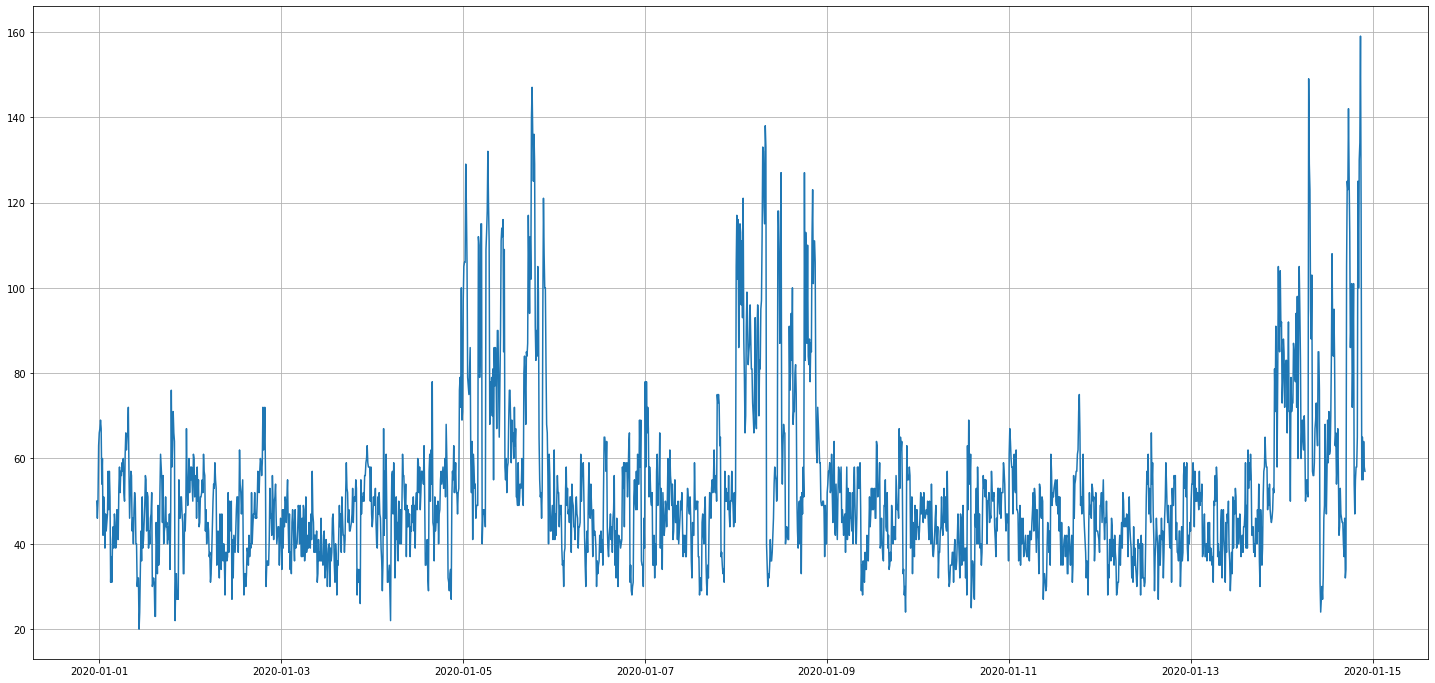

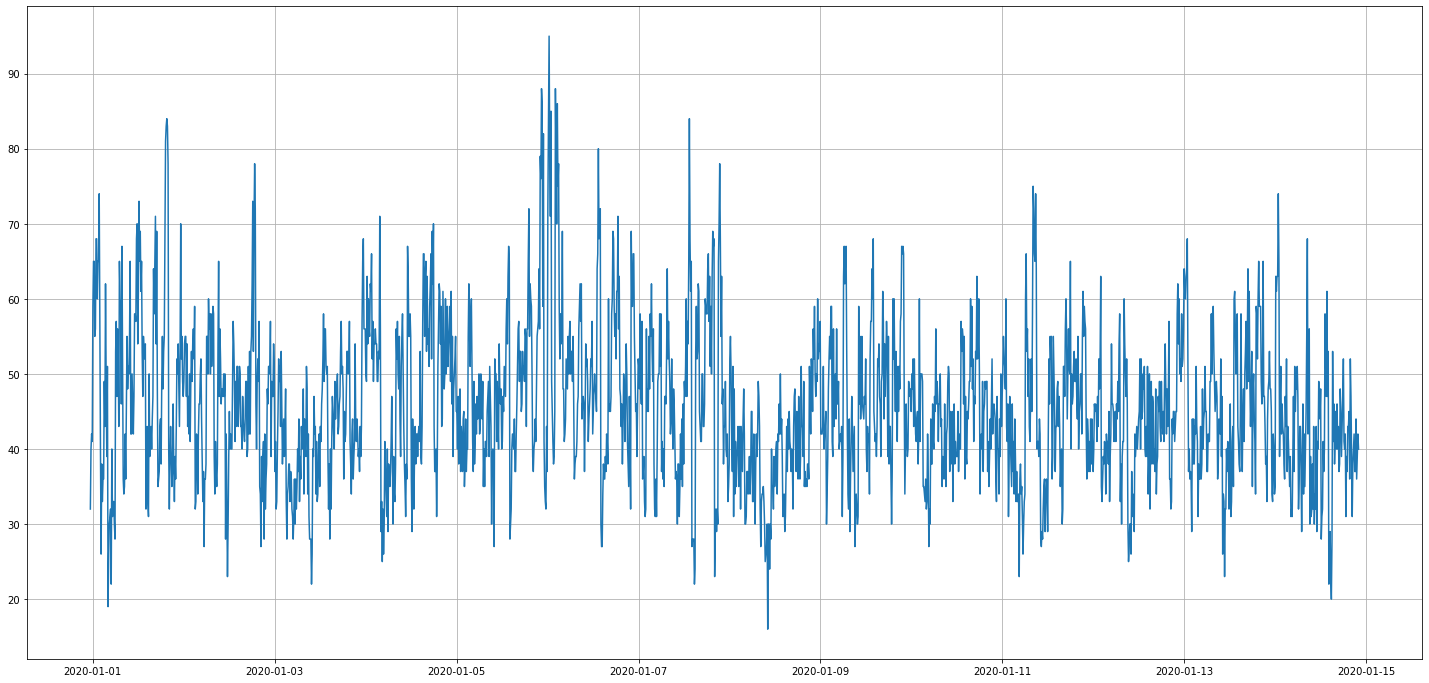

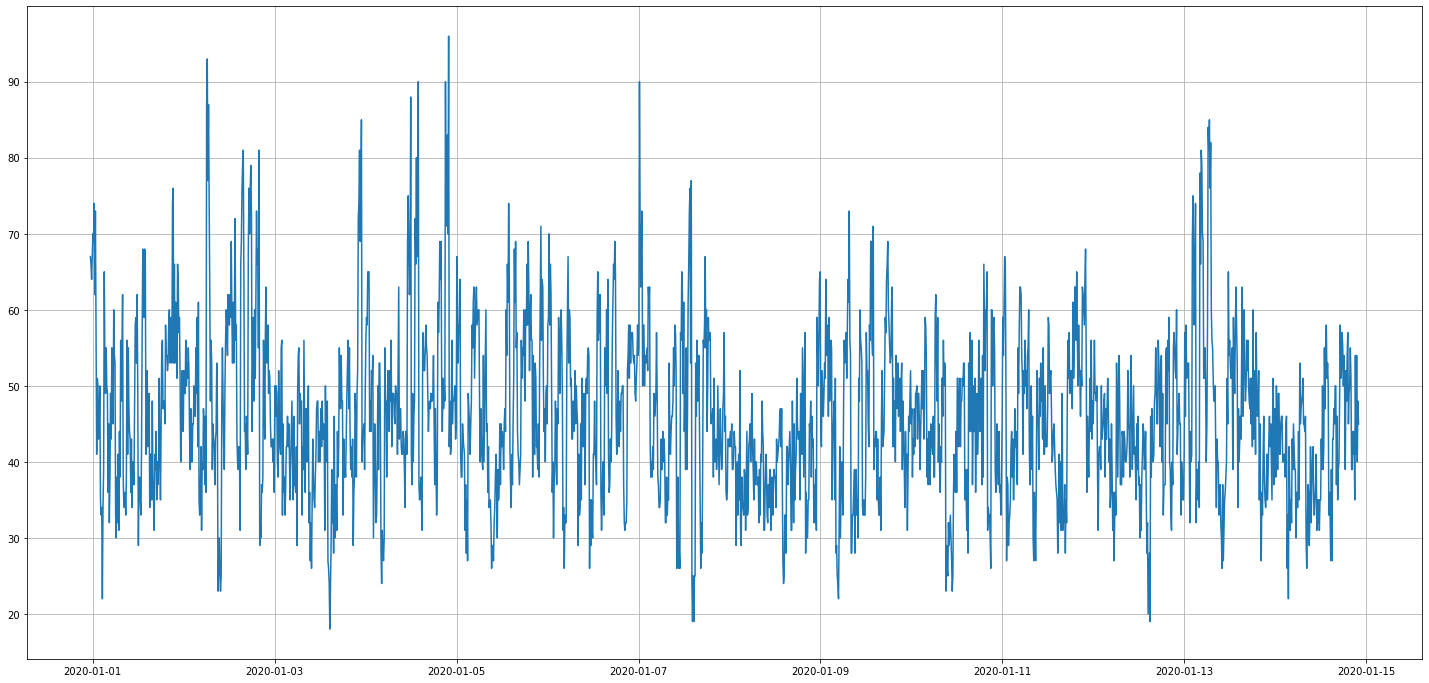

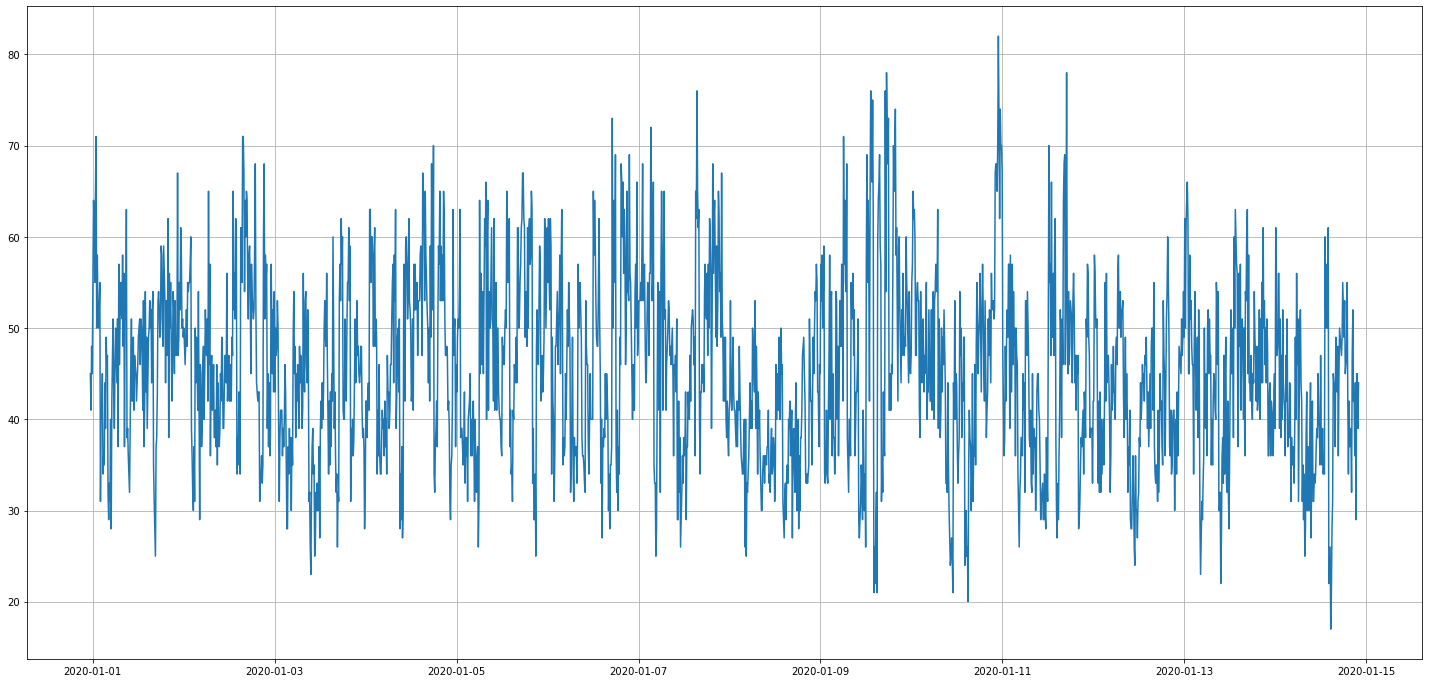

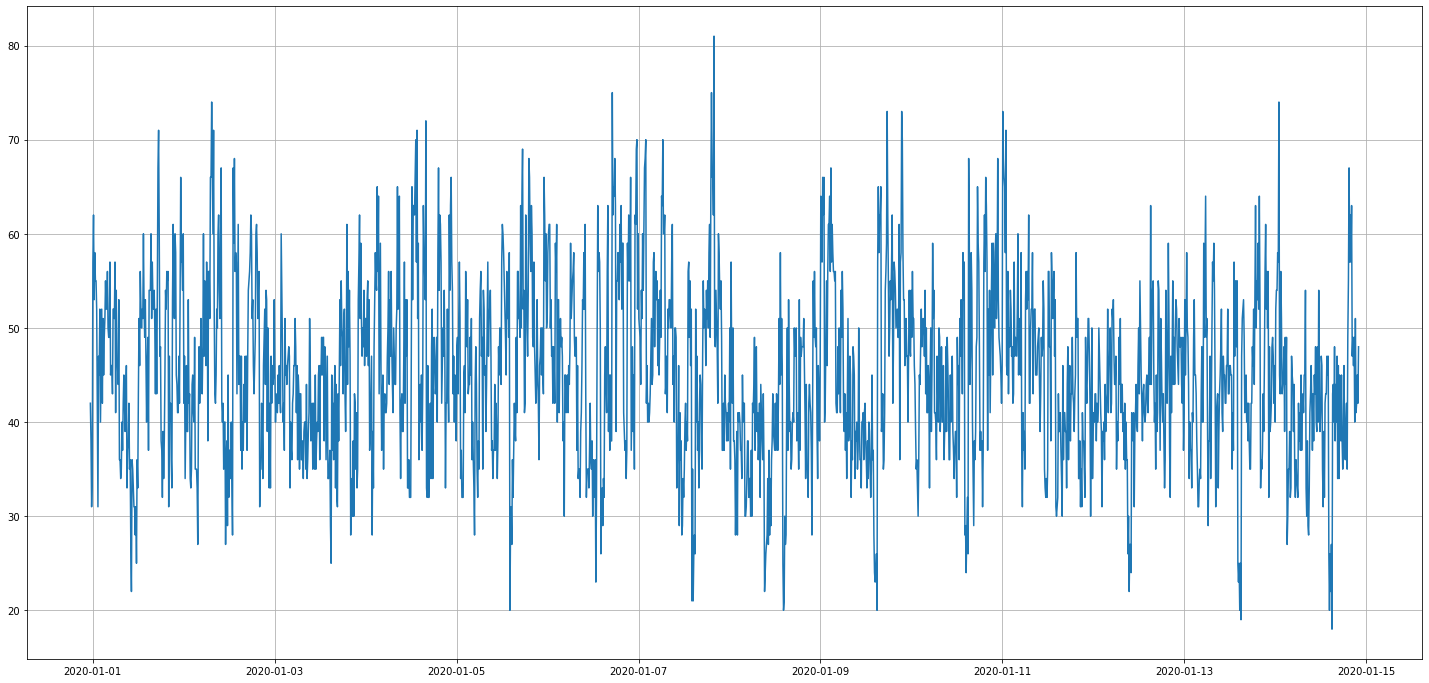

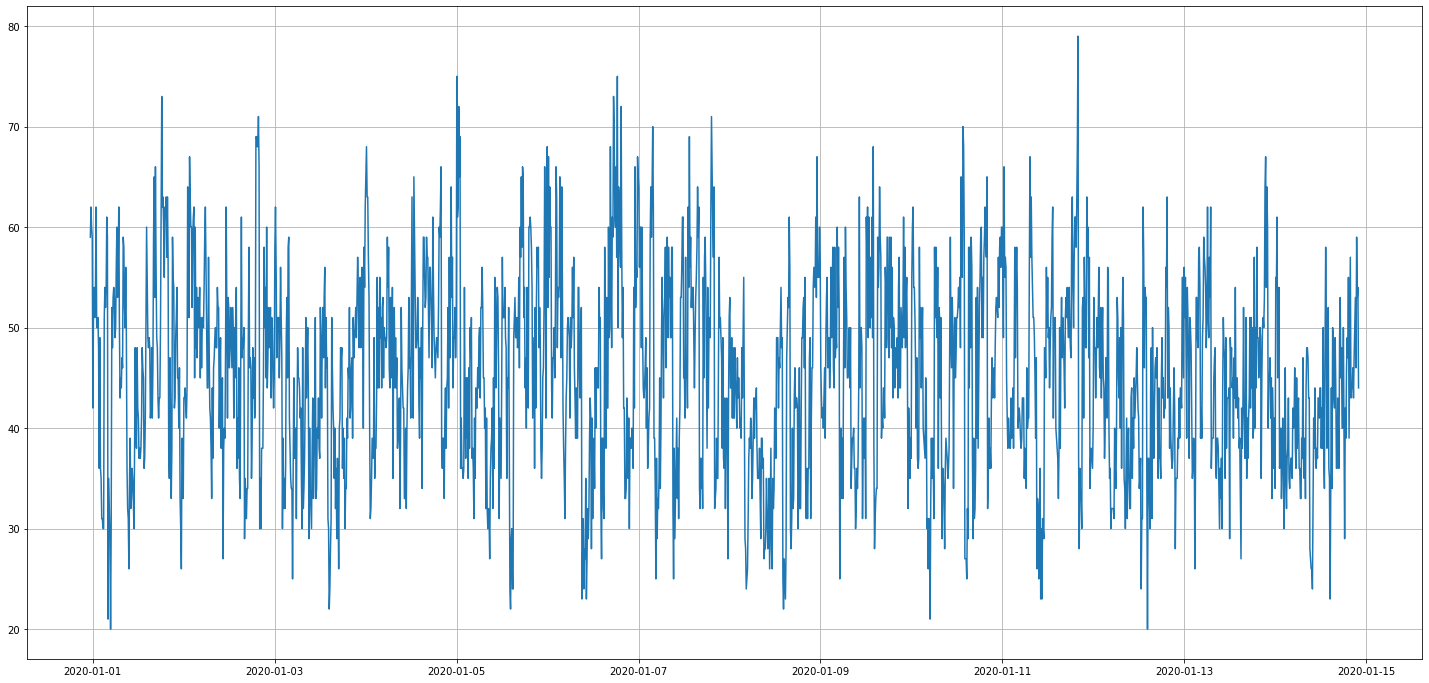

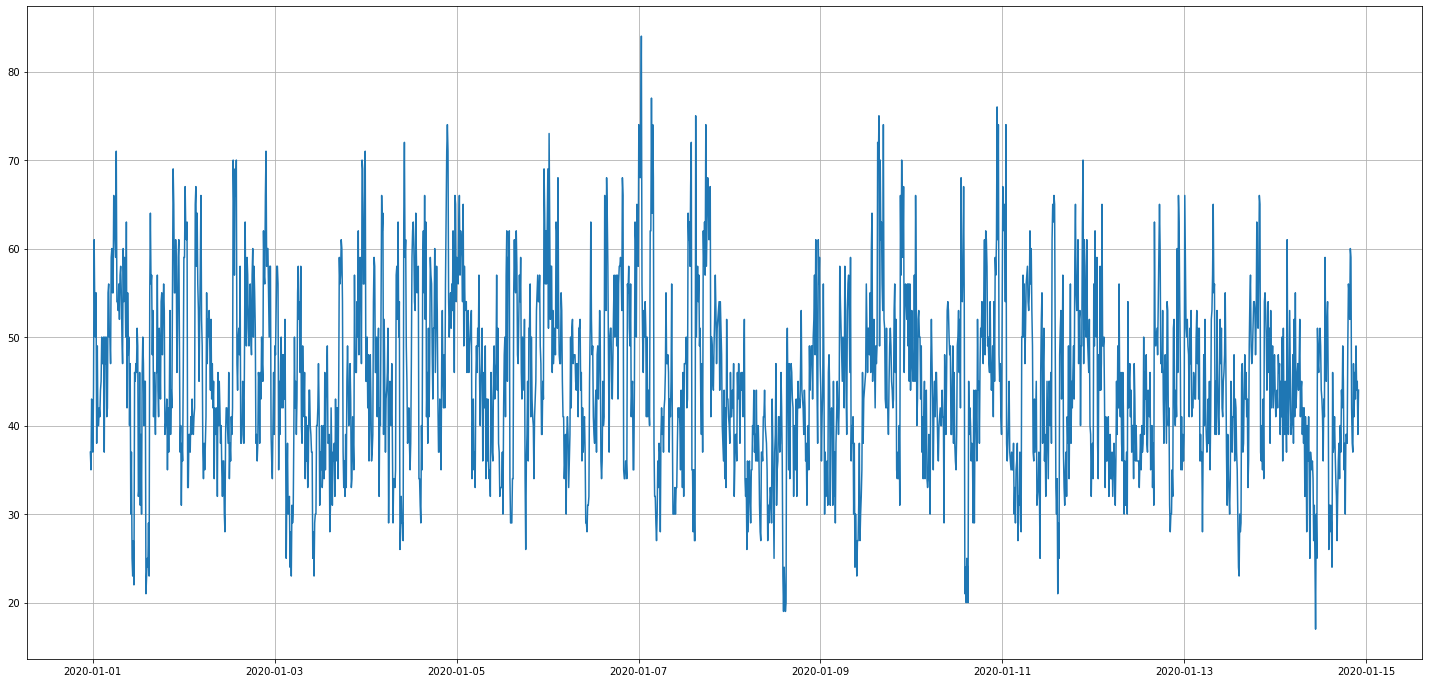

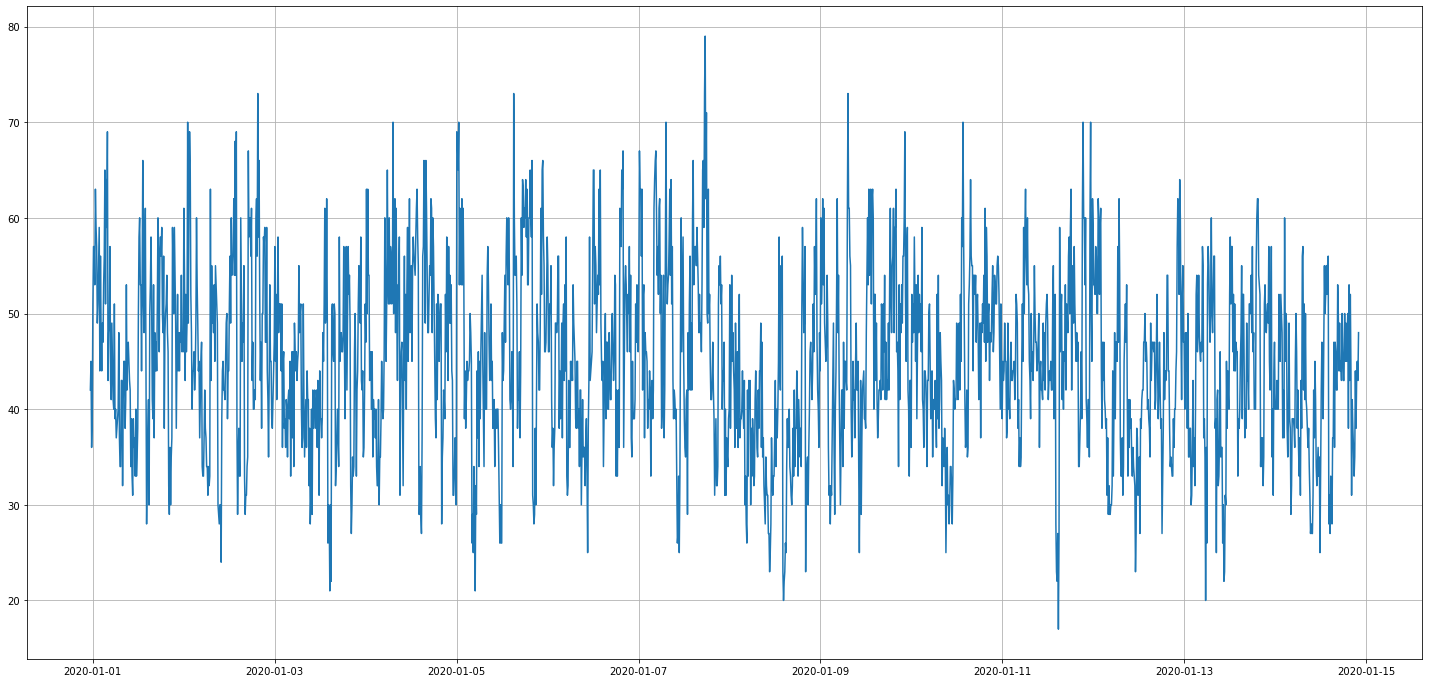

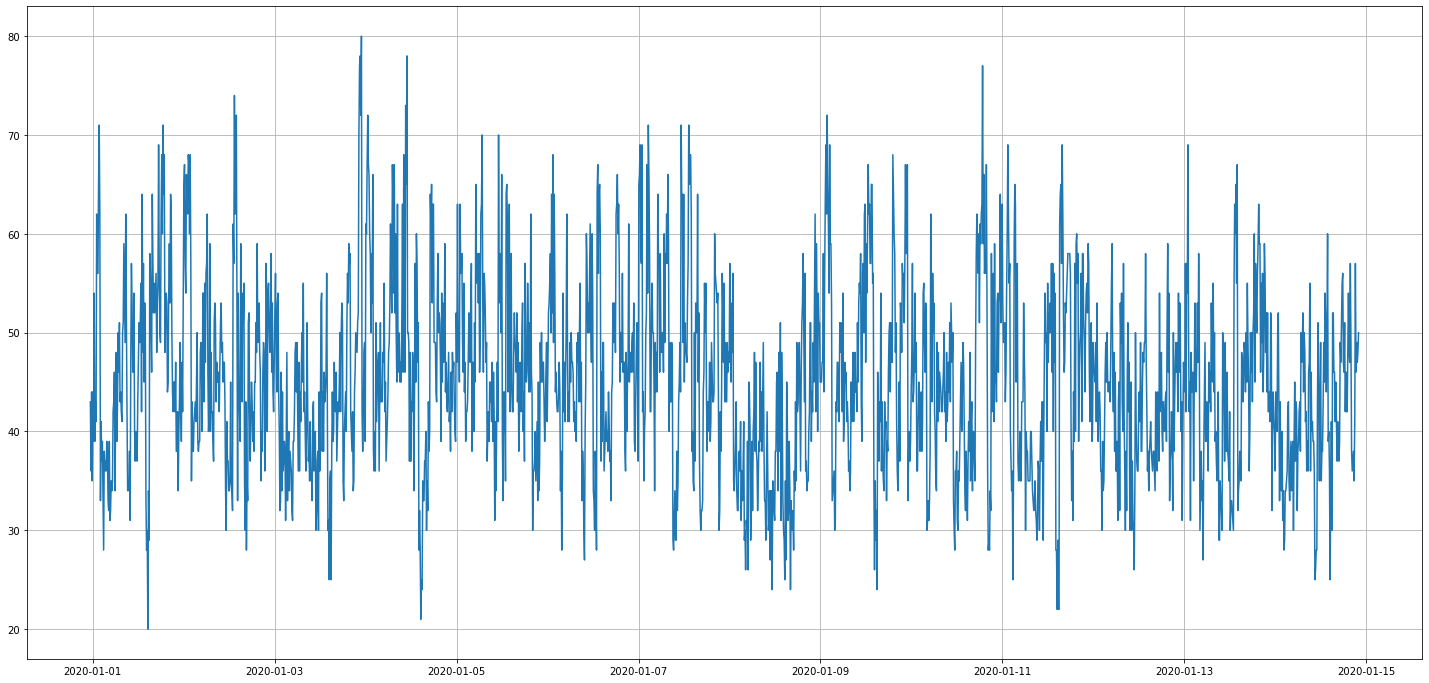

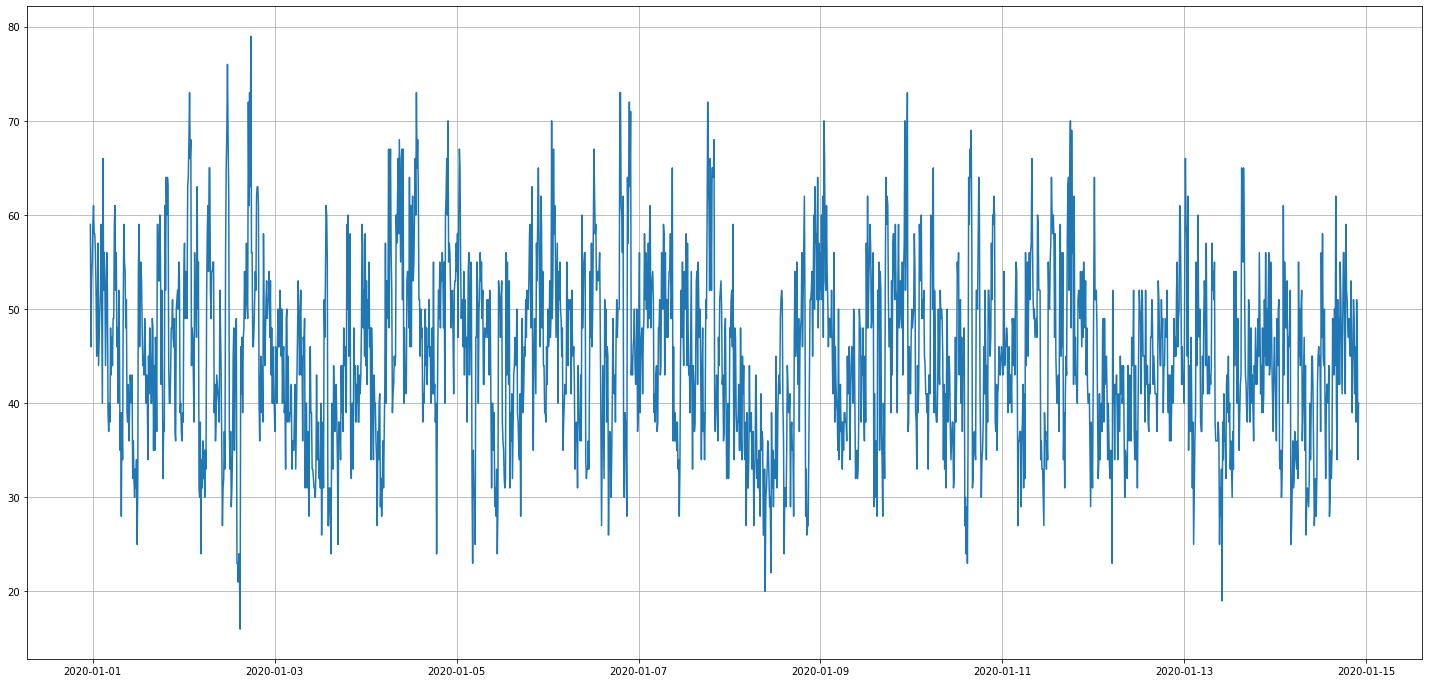

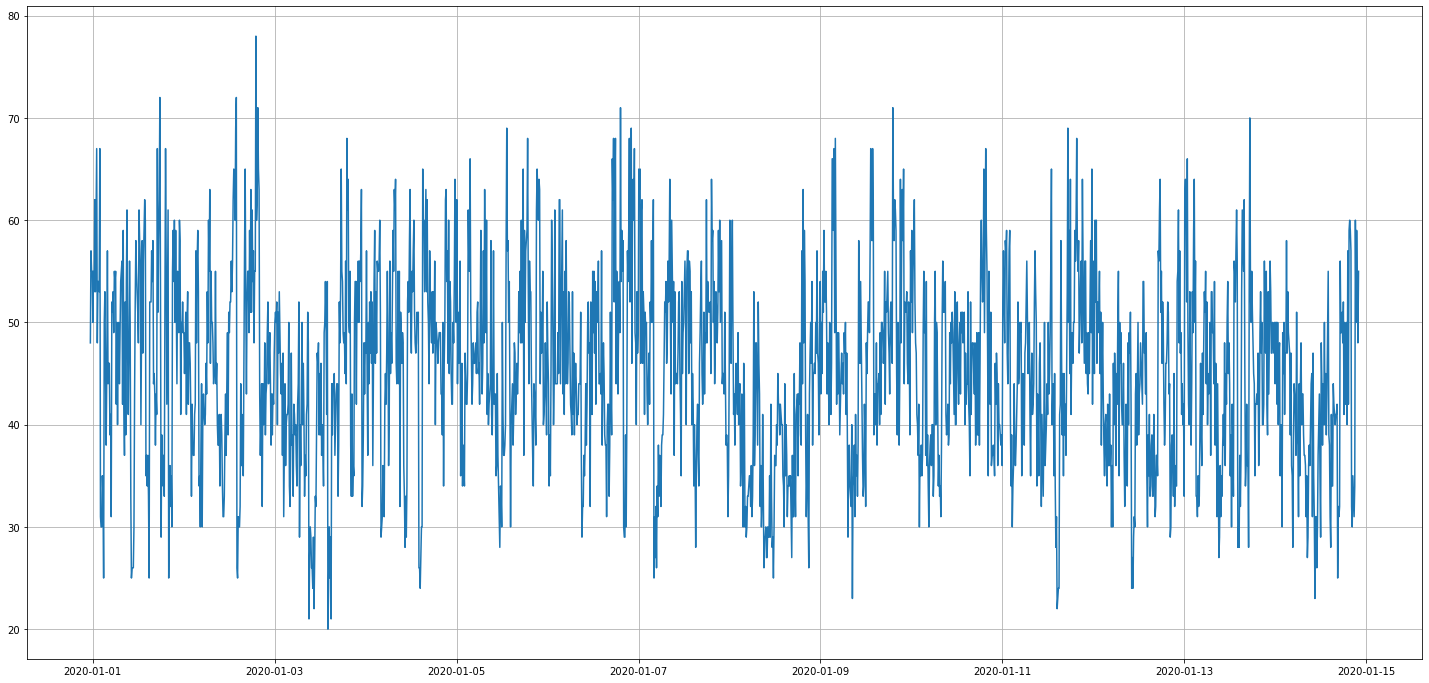

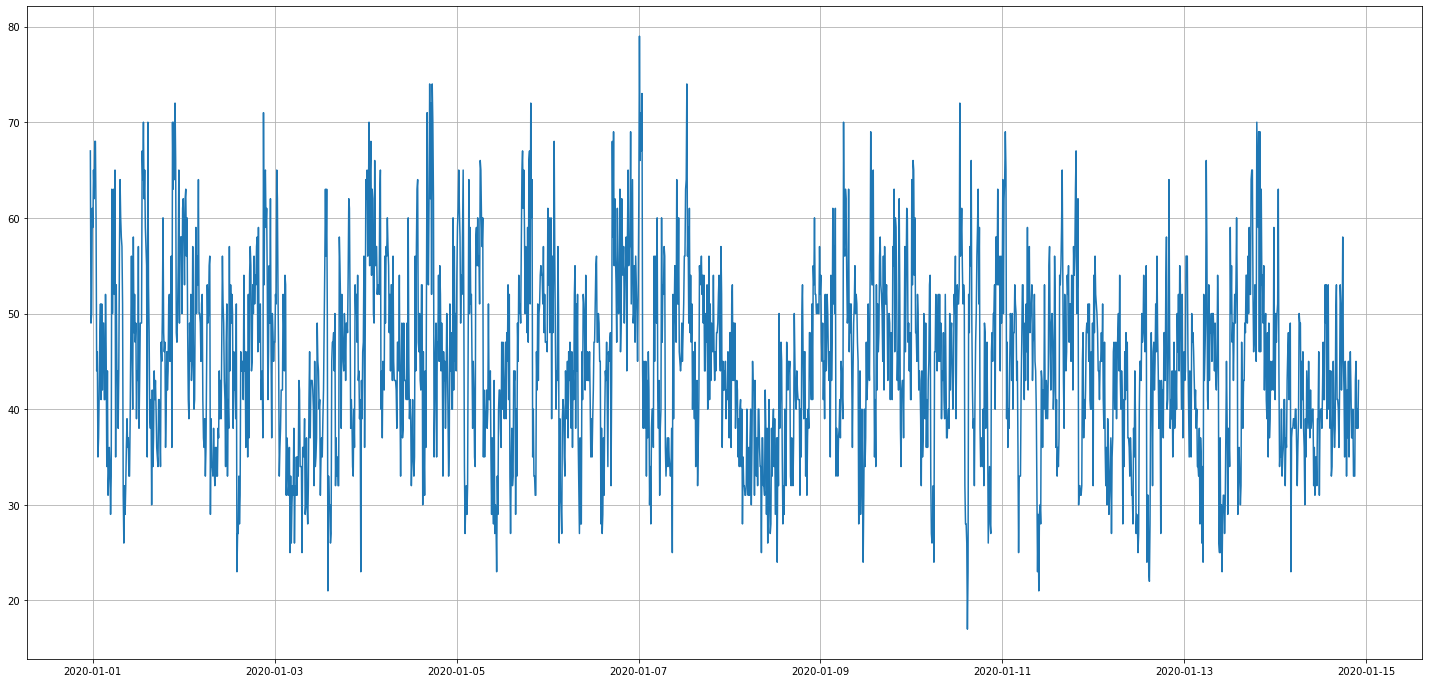

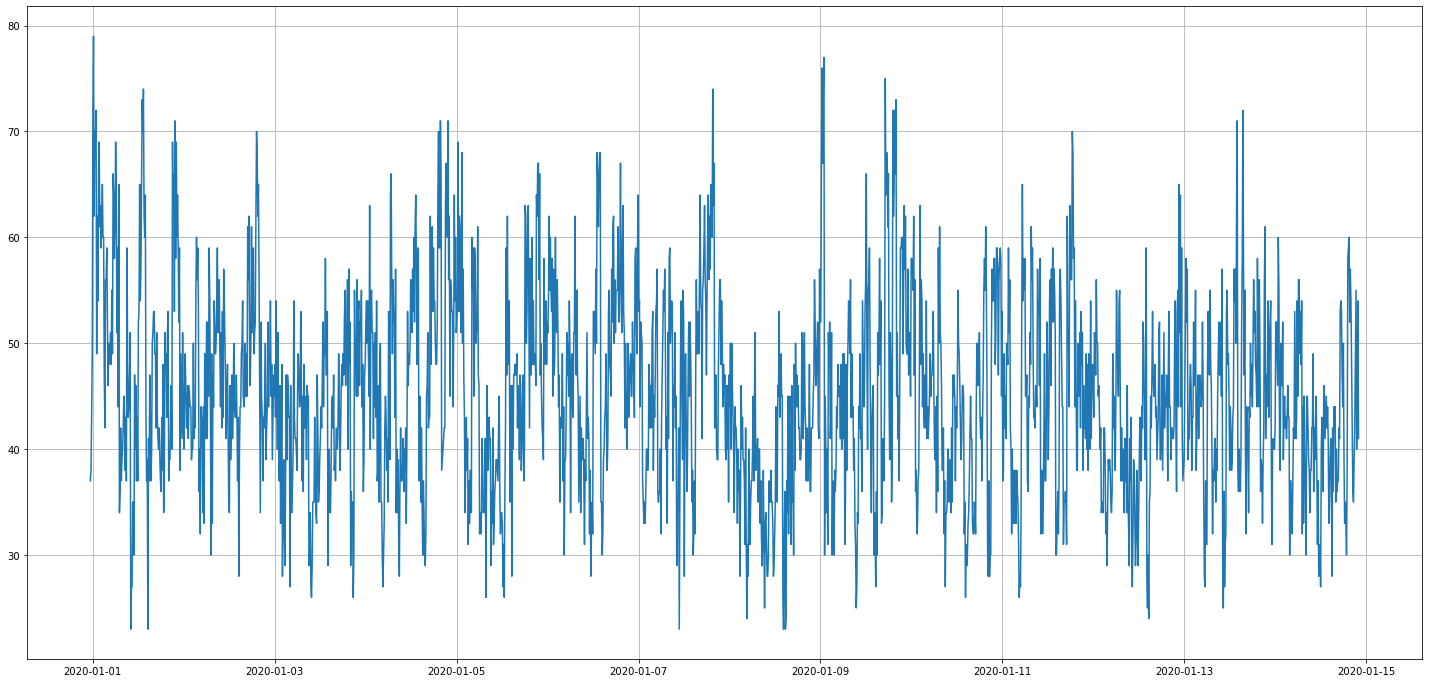

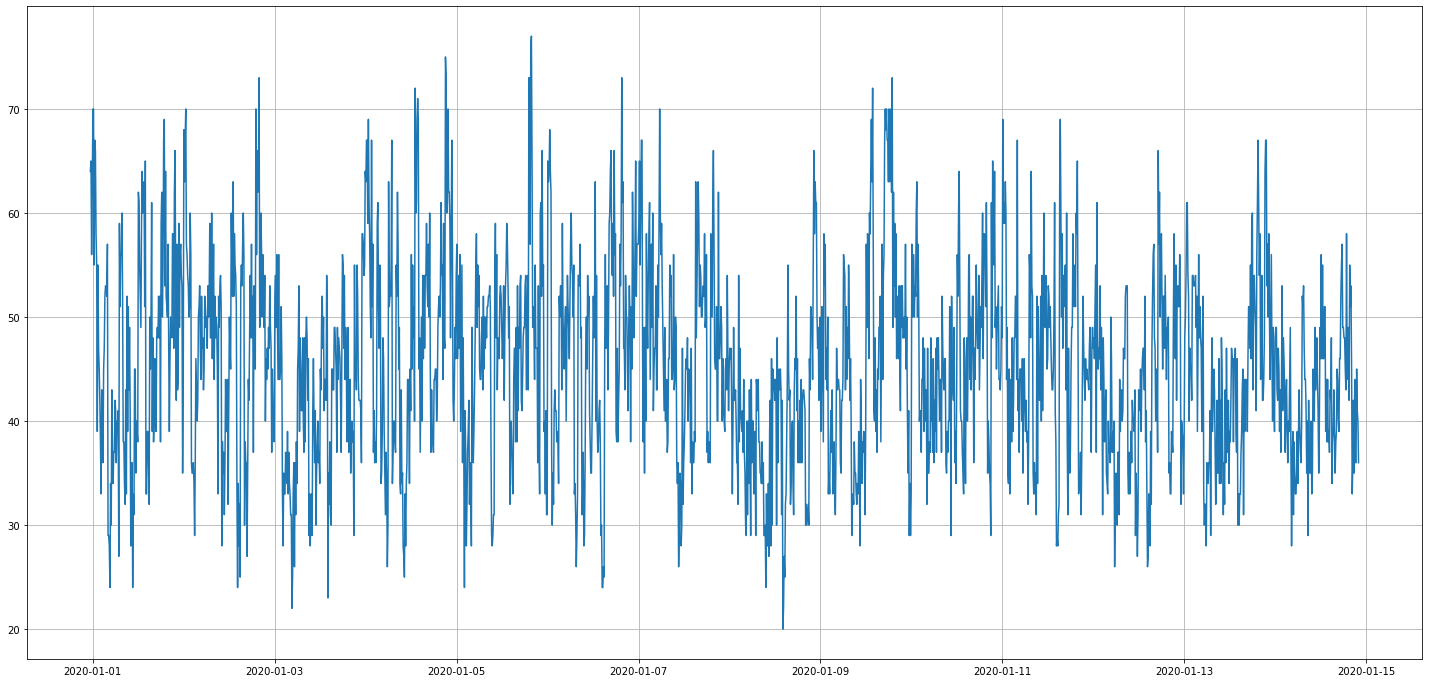

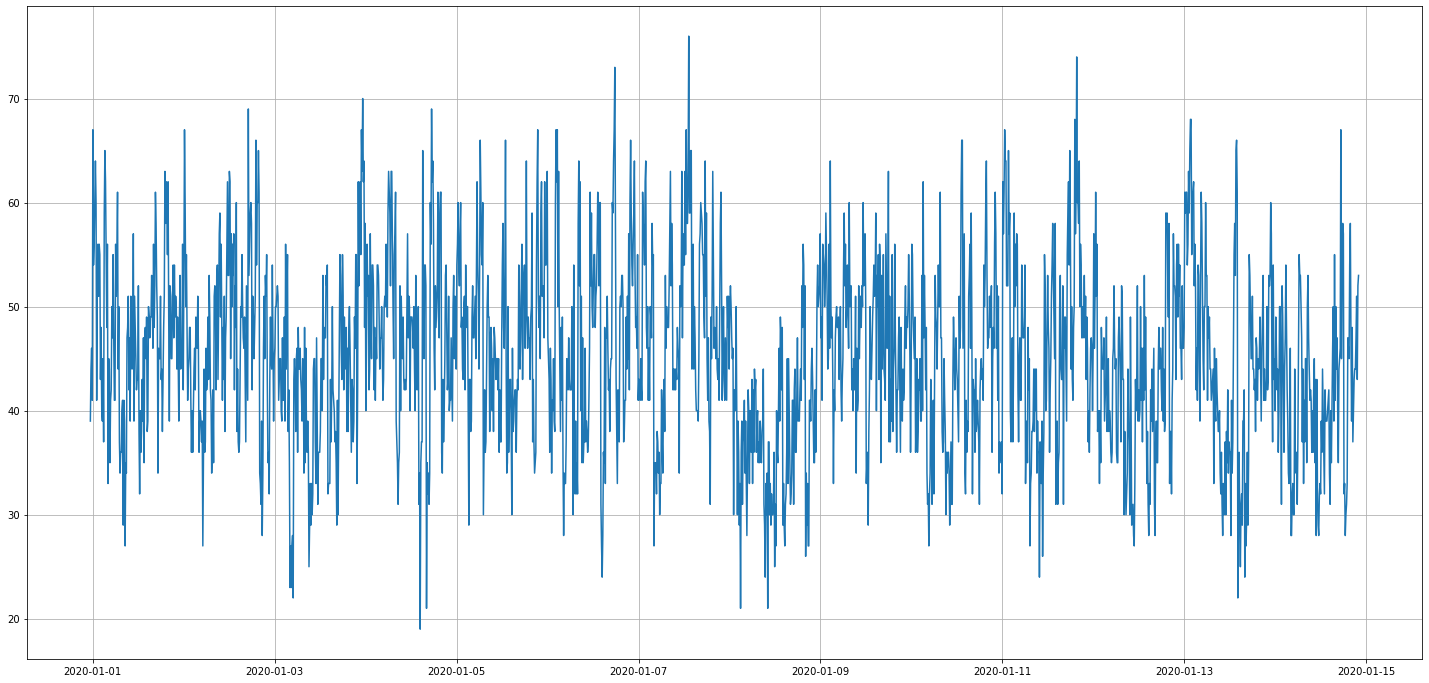

In [25]:
abnormalities = {dim: irr for dim, irr in zip(abnormalities_df[dimensions[0]], abnormalities_df.irregulations.tolist())}

abnormal_series = {}
for abnoraml_id, series in training.groupby(dimensions):
    if abnoraml_id in abnormalities.keys():
        abnormal_series[abnoraml_id] = series

for abnoraml_id in abnormalities.keys():
    series = abnormal_series[abnoraml_id]
    series.sort_index(inplace=True)
    series['time'] = pd.to_datetime(series.index, unit='s')
    only_anomalies = series[series.global_anomaly_flag==-1]

    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(series.time, series.User_size)
    plt.scatter(only_anomalies.time, only_anomalies.User_size, color='red')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Series id {abnoraml_id}. Num of irregultations found {abnormalities[abnoraml_id]}', fontsize=20)
    

In [ ]:
import matplotlib.pyplot as plt

for anomaly_pred_df in anomaly_pred_dfs:
    anomaly_pred_df.sort_index(inplace=True)
    anomaly_pred_df['time'] = pd.to_datetime(anomaly_pred_df.index, unit='s')
    only_anomalies = anomaly_pred_df[anomaly_pred_df.anomaly_flag==-1]

    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(anomaly_pred_df.time, anomaly_pred_df.User_size)
    plt.scatter(only_anomalies.time, only_anomalies.User_size, color='red')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Number of request in {period} sec period to {tuple(anomaly_pred_df[dimensions].values[0])} due time', fontsize=20)
    plt.show()

In [ ]:
local_isf_params = {
    'random_state': 0,
    'n_estimators': 80,
    'max_features': 0.75,
    'verbose': 0,
    'contamination': 0.005
    
}

#
# # find user and route
# anomaly_pred_dfs: Dict[str, Dict[str, pd.DataFrame]] = defaultdict(dict) 
# for dim, dim_data in training.groupby(dimensions):
#     isf.fit(dim_data[dim_data.columns.difference(dimensions)])
    
#     # set anomaly score
#     anomaly_score = isf.score_samples(dim_data[dim_data.columns.difference(dimensions)])
#     anomaly_flag = isf.predict(dim_data[dim_data.columns.difference(dimensions)])

#     dim_data['anomaly_score'] = anomaly_score
#     dim_data['anomaly_flag'] = anomaly_flag
#     anomaly_pred_dfs[dim[0]][dim[1]] = dim_data